In [7]:
import numpy as np
import sklearn.datasets as datasets
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline


### Goal: Use sklearn's breast cancer dataset to classify cell features as malignant or benign with a single layer perceptron NN.

To train the neuron:

1. Forward pass: Ask the neuron to classify a sample.
2. Update the neuron’s weights based on how wrong the prediction is. 
3. Repeat.

In [2]:
# Functions 

def sigmoid(x):
    """
    Activation function for the single layer perceptron.
    Chosen because it is easily differentiable, non-linear, and bounded.
    """
    return 1/(1+np.exp(-x))


def dsigmoid(y):
    """
    Derivative of the sigmoid function. Useful for minimizing the error of the
    neuron's predictions.
    """
    return y*(1-y)


def mean_squared_error(y, pred):
    """
    Error function representing the scaled version of mean squared error.
    Function used to
    """
    return np.mean(np.square(y - pred))/2


In [8]:
df = pd.read_csv('breast_cancer_data.csv')
print(df.head())

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

      ...       texture_worst  perimeter_worst  area_worst  sm

In [5]:
# Step 1A: Load the data
breast_cancer_data = datasets.load_breast_cancer()

print('Class Labels: {}'.format(breast_cancer_data.target_names))
print('Dataset Shape: {}'.format(breast_cancer_data.data.shape))  # (569, 30) - (num_instances, num_features)
print('Dataset features: {}'.format(breast_cancer_data.feature_names))
print('{} vals in sample: {}'.format(breast_cancer_data.target_names[0], np.count_nonzero(breast_cancer_data['target'] == 0)))
print('{} vals in sample: {}'.format(breast_cancer_data.target_names[1], np.count_nonzero(breast_cancer_data['target'] == 1)))
x = breast_cancer_data['data']  # array of features with shape: (n_samples, n_features)
y = breast_cancer_data['target']  # array of binary values for the two classes: (n_samples)


Class Labels: ['malignant' 'benign']
Dataset Shape: (569, 30)
Dataset features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
malignant vals in sample: 212
benign vals in sample: 357


In [4]:
# Step 1B: Randomize the data
shuffle_ind = np.random.permutation(len(x))  # shuffle data for training

x = np.array(x[shuffle_ind])
y = np.array(y[shuffle_ind])[np.newaxis].T  # convert y to a column to make it more consistent with x

x /= np.max(x)  # linearly scaling the inputs to a range between 0 and 1, sigmoid function is bounded (0 to 1)


In [5]:
# Step 1C: Break the data into training, testing sets
train_fraction = 0.75
train_idx = int(len(x)*train_fraction)

x_train = x[:train_idx]
y_train = y[:train_idx]

x_test = x[train_idx:]
y_test = y[train_idx:]

In [6]:
# Step 1D: Initialize a single layer (vector) of weights with Python's matrix package numpy
W = 2*np.random.random((np.array(x).shape[1], 1)) - 1  # shape: (n_features * 1)

#### Step 2: Forward Pass + Update the neuron's weights

With the bounded predictions `l1`, we need to calculate the error/loss in these predictions and update neuron weights. We'll use the gradient descent optimization algorithm for weight updates.

First we need to calculate the error function to use gradient descent. The error function will help update the weights by calculating the distance between the neuron's predictions and ground truth (label). This is captured in `l1_error`. 

We must then obtain the gradient (`l1_gradient`), or the partial derivatives in respect to each weight, to minimize the error. These gradient vectors have a magnitude and a direction.

Multiplying the `l1_error` with the `l1_gradient` leaves a `l1_delta`.

Lastly, we need to apply the `l1_delta` to the original inputs (`10`) to get the `l1_weighted_delta` to apply to the original weights `W1`. Ultimately our `lr` (learning rate) decides how large a "step" to take in updating the weights `W`.


In [16]:
lr = 0.5  # learning rate
history = {"loss": [], "val_loss": [], "acc": [],
           "val_acc": []}  # Metrics to track while training
epochs = 1000

for iter in range(epochs):  # Step 2C: Repeat!
    
    # Step 2A: Training - Forward Pass, ask the neuron to predict on the training samples
    l0 = x_train  # layer 0 output, the matrix of features shape:(n_samples * n_features)
    l1 = sigmoid(np.matmul(l0, W))  # perceptron output, or the class predictions for each training sample

    l1_error = l1 - y_train  # backward pass, output layer error, how much did we miss?

    l1_gradient = dsigmoid(l1)  # minimize the error w/derivative func
    
    l1_delta = np.multiply(l1_error, l1_gradient)  # how much did we miss by the slope of the sigmoid

    l1_weight_delta = np.matmul(l0.T, l1_delta)  # calculate the weight update by applying delta to all weights
    
    # Step 2B: Update the weights!
    W -= l1_weight_delta * lr  # update weights with a scaling factor of learning rate
    # 30 weights for each feature
    if iter % 100 == 0:
        # Recording metrics to understand the performance of neuron at each epoch
        train_loss = mean_squared_error(y_train, l1)
        train_acc = np.sum(y_train == np.around(l1))/len(x_train)
        history["loss"].append(train_loss)
        history["acc"].append(train_acc)
        val_pred = sigmoid(np.dot(x_test, W))  # generates 143 predictions
        val_loss = mean_squared_error(y_test, val_pred)
        val_acc = np.sum(y_test == np.around(val_pred))/len(x_test)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print('Epoch: {}, Training Loss: {}, Validation Acc: {}'.format(
            iter, train_loss, val_acc))


Epoch: 0, Training Loss: 0.051470875251217144, Validation Acc: 0.8951048951048951
Epoch: 100, Training Loss: 0.05017694626413993, Validation Acc: 0.8951048951048951
Epoch: 200, Training Loss: 0.049037144056162704, Validation Acc: 0.8951048951048951
Epoch: 300, Training Loss: 0.048022351294910275, Validation Acc: 0.8951048951048951
Epoch: 400, Training Loss: 0.04711020058168321, Validation Acc: 0.8951048951048951
Epoch: 500, Training Loss: 0.04628307504814058, Validation Acc: 0.8951048951048951
Epoch: 600, Training Loss: 0.04552675752572004, Validation Acc: 0.8951048951048951
Epoch: 700, Training Loss: 0.04482949426902259, Validation Acc: 0.8951048951048951
Epoch: 800, Training Loss: 0.044181345076799085, Validation Acc: 0.8951048951048951
Epoch: 900, Training Loss: 0.04357376495405066, Validation Acc: 0.9020979020979021


In [8]:
# Results
val_pred = sigmoid(np.dot(x_test, W))
print("Validation loss: {}".format(mean_squared_error(y_test, val_pred)))
print("Validation accuracy: {}".format(
    np.sum(y_test == np.around(val_pred))/len(x_test)))


Validation loss: 0.05215941750822036
Validation accuracy: 0.9020979020979021


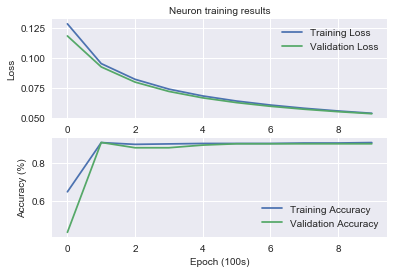

In [12]:
# Step 3: Plotting Results
sns.set()
fig = plt.figure()
plt_1 = plt.subplot(2, 1, 1)
plt.plot(history['loss'], label="Training Loss")
plt_1.set_ylabel('Loss', fontsize=10)
plt_1.set_title('Neuron training results', fontsize=10)
plt.plot(history['val_loss'], label="Validation Loss")
plt.legend()

plt_2 = plt.subplot(2, 1, 2)
plt.plot(history['acc'], label="Training Accuracy")
plt.plot(history['val_acc'], label="Validation Accuracy")
plt_2.set_xlabel('Epoch (100s)', fontsize=10)
plt_2.set_ylabel('Accuracy (%)', fontsize=10)
plt.legend()

plt.show()
